# This book combines soybean weekly forecasts with an artificial bee colony algorithm

### CONTENTS

### 1 Imports
### 2 Define error functions
### 3 Load and evaluate individual forecasts
### 4 Set ABC parameters
### 5 Initialise ABC data structures
### 6 Define ABC functions
### 7 Complete ABC forecast combination
### 8 Compare ABC with naive combinations
### 9 Compare combinations with error-informed discretised search

# 1 Imports

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import random

import matplotlib.pyplot as plt
import matplotlib.dates

from google.colab import drive
import json

# 2 Define error functions

In [2]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns mean absolute percentage error
def mape(forecast, actual):
  return np.mean(np.abs(forecast - actual)/np.abs(actual))

In [3]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns root mean squared error
def rmse(forecast, valid):
    return (np.mean((forecast - valid)**2))**.5  # RMSE

# 3 Load and evaluate individual forecasts

In [4]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/kumars8/Deloitte_login_prjct/master/soybean_weekly.csv'
soybean_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
soybean_df.columns = ['value']

# take only 1974 - 2017
soybean_df = soybean_df['1974-01-01':'2017-12-31']

# soybean_df needs to lose last value becuase during process of VMD, the last value is lost
soybean_df = soybean_df[:-1]

# get validation set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(soybean_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [5]:
# flatten the valid set for comparing with forecasts
true_valid = true_valid.values.flatten()

In [6]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
# Load emd_arima
with open('/content/gdrive/MyDrive/outputs/test/emd_ARIMA_weekly_valid.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/MyDrive/outputs/test/vmd_ARIMA_weekly_valid.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/emd_RNN_weekly_valid.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/vmd_RNN_weekly_valid.npy')

# Load true_RNN
true_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/true_RNN_weekly_valid.npy')

In [25]:
# Check shapes
print(true_valid.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(229,)
(229,)
(229,)
(229,)
(229,)
(229,)


In [26]:
# Check individual mape scores
print(mape(emd_arima, true_valid))
print(mape(vmd_arima, true_valid))
print(mape(emd_RNN, true_valid))
print(mape(vmd_RNN, true_valid))
print(mape(true_RNN, true_valid))

0.01450606283840767
0.01408077994944636
0.018862901102025452
0.013455253953235784
0.024606922305900336


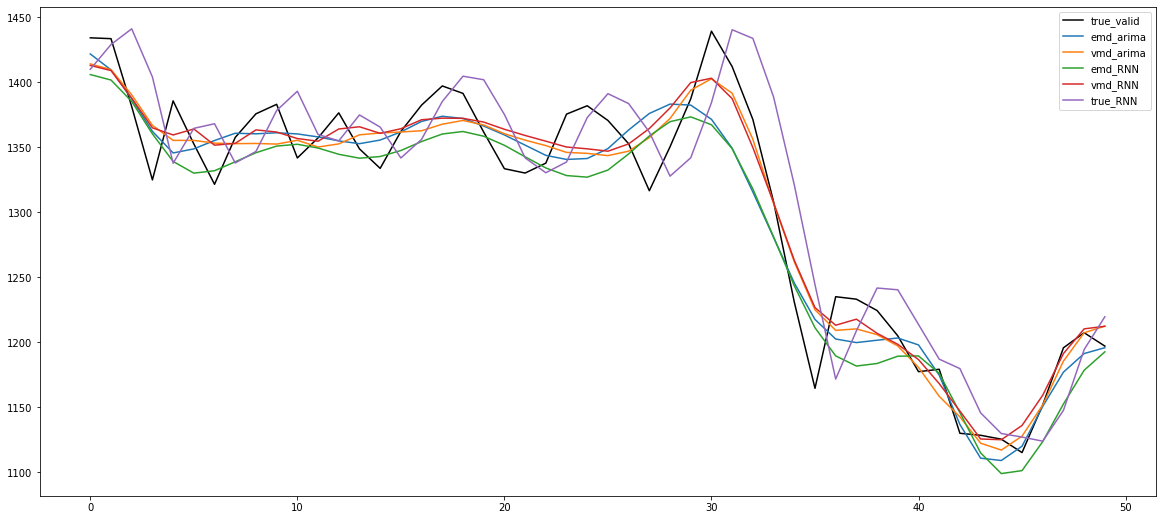

In [28]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_valid[100:150], label='true_valid', color='k')
plt.plot(emd_arima[100:150], label='emd_arima')
plt.plot(vmd_arima[100:150], label='vmd_arima')
plt.plot(emd_RNN[100:150], label='emd_RNN')
plt.plot(vmd_RNN[100:150], label='vmd_RNN')
plt.plot(true_RNN[100:150], label='true_RNN')
plt.legend()
plt.show()

In [29]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[ 850.29570147,  876.03573606,  842.70611572,  877.86883545,
         874.5322876 ],
       [ 884.91791101,  885.34173656,  854.980896  ,  891.36999512,
         863.66937256],
       [ 924.15174264,  909.53709398,  887.22711182,  916.28430176,
         886.0279541 ],
       ...,
       [1577.35705041, 1553.66847324, 1561.99243164, 1554.78796387,
        1531.63366699],
       [1568.3890968 , 1538.93306942, 1561.78479004, 1534.69335938,
        1576.80322266],
       [1528.76800152, 1493.39498581, 1534.95910645, 1482.74914551,
        1608.33984375]])

# 4 Set ABC parameters

In [30]:
# make a variable counting number of base models involved
no_of_models = len(model_matrix[0])

# swarm size
SN = 350

# number of iterations through solution set
iter_stop_no = 5000

# the minimum possible weight during swarm initialisation
xmin = 0.1

# the maximum possible weight during swarm initialisation
xmax = 0.3

# the minimum number of bees in the elitist colony
min_elite_no = 8

# the number of tries without improvement, after which the solution is abandoned for new territory
trial_limit = 10

# 5 Initialise ABC data structures

In [31]:
# Make randomly initialized direction factor matrix
# This matrix makes it less likely that an unpromising avenue will be searched again in the same direction 

np.random.seed(42)
dir_factor = np.random.choice([-1,1], SN * no_of_models)
dir_factor = dir_factor.reshape(SN, no_of_models)
dir_factor

array([[-1,  1, -1, -1, -1],
       [ 1, -1, -1, -1,  1],
       [-1, -1, -1, -1,  1],
       ...,
       [ 1, -1, -1, -1, -1],
       [ 1,  1,  1, -1,  1],
       [ 1,  1, -1, -1, -1]])

In [32]:
# Trial array, tracking the number of changes without getting any improvements
# Once any value exceeds the value of trial_limit, the corresponding solution will be abandoned in search of a new random solution

trial_arr = np.full(SN, 0)
trial_arr

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
# Initialise the colony
colony = np.full((SN, no_of_models), xmin) + np.random.rand(SN, no_of_models) * (xmax - xmin)

# 6 Define ABC functions

In [34]:
# Takes model_matrix and the colony
# Returns a 1d array giving RMSE for every solution in colony
def evaluate_colony(model_matrix, colony, valid):

  colony_rmse = []

  for row in np.transpose(model_matrix.dot(np.transpose(colony))):
    colony_rmse.append(rmse(row, valid))
    
  return np.array(colony_rmse)

In [35]:
# Takes model_matrix, a single solution and the validation set
# Returns the rmse figure for that single solution
def evaluate_solution(model_matrix, solution, valid):
  return rmse(model_matrix.dot(solution), valid)

In [36]:
# Takes the number of bees to be in elitist colony at present, the colony evaluation and the colony
# Returns the solutions to make up current elitist colony
def generate_elitist_colony(elitist_no, colony_eval, colony):
  sort_ints = np.argsort(colony_eval)
  #return colony[sort_ints[:elitist_no]], colony_eval[sort_ints[-elitist_no::-1]]
  return colony[sort_ints[:elitist_no]]

In [37]:
# Takes the colony and its evaluation
# Returns a fitness evaluation of each solution
def generate_fitness_probs(colony, colony_eval):
  min_max_sum = max(colony_eval) + min(colony_eval)
  inverted_fitness = np.full(SN, min_max_sum)
  inverted_fitness = inverted_fitness - colony_eval
  inverted_fitness = inverted_fitness / sum(inverted_fitness)
  return inverted_fitness

In [38]:
# Take swarm size, current iteration, iter_stop_no and min_elite_no
# Return the number of bees to make up the elitist colony ar present
def elitist_no(SN, i, iter_stop_no, min_elite_no):
  return round(max(SN - (SN * (i / iter_stop_no)), min_elite_no))

In [39]:
# Take no_of_models, a solution, a random elitist solution, and the relevant row from dir_factor
# Return an altered version which is hoped to have lower error, as well as the location of the element which was altered

def generate_candidate(no_of_models, solution, elitist_solution, dir_factor_row):
  element = np.random.choice(no_of_models)
  
  candidate = solution.copy()

  candidate[element] += abs(candidate[element] - elitist_solution[element]) * dir_factor_row[element] * np.random.rand()

  return candidate, element

In [40]:
# This function makes use of all above information and implements ABC algorithm in full as outlined by Wang
def LL_ABC(SN, iter_stop_no, no_of_models, valid, xmin, xmax, min_elite_no, trial_limit):

  np.random.seed(42)
  elite_no = elitist_no(SN=SN, i=0, iter_stop_no=iter_stop_no, min_elite_no=min_elite_no)

  lowest_err = 99
  best_solution = []
  elitist_colony = generate_elitist_colony(elitist_no=elite_no, colony_eval=evaluate_colony(model_matrix, colony, valid), colony=colony)

  # Employed bee phase
  for i in range(SN):
    solution = colony[i]
    solution_error = evaluate_solution(model_matrix, solution, valid)

    if solution_error < lowest_err:
      lowest_err = solution_error
      best_solution = solution.copy()

    candidate, element = generate_candidate(no_of_models=no_of_models
                                            ,solution=solution
                                            ,elitist_solution=elitist_colony[np.random.choice(elite_no)]
                                            ,dir_factor_row=dir_factor[i])

    candidate_error = evaluate_solution(model_matrix, candidate, valid)

    if candidate_error < solution_error:
      trial_arr[i] = 0
      colony[i] = candidate.copy()
      if candidate_error < lowest_err:
        lowest_err = candidate_error
        best_solution = candidate.copy()
    else:
      dir_factor[i][element] *= -1
      trial_arr[i] += 1

  for i in range(iter_stop_no):

      fitness_arr = generate_fitness_probs(colony=colony
                                           ,colony_eval=evaluate_colony(model_matrix, colony, valid))
    
      elite_no = elitist_no(SN=SN, i=i, iter_stop_no=iter_stop_no, min_elite_no=min_elite_no)
      elitist_colony = generate_elitist_colony(elitist_no=elite_no, colony_eval=evaluate_colony(model_matrix, colony, valid), colony=colony)
      t = 0

      # Onlooker phase
      while t < SN:

        fitness_threshold = np.random.rand()

        for j in range(SN):
          if fitness_arr[j] > fitness_threshold:
            solution = colony[j]
            solution_error = evaluate_solution(model_matrix, solution, valid)

            if solution_error < lowest_err:
              lowest_err = solution_error
              best_solution = solution.copy()

            candidate, element = generate_candidate(no_of_models=no_of_models
                                                    ,solution=solution
                                                    ,elitist_solution=elitist_colony[np.random.choice(elite_no)]
                                                    ,dir_factor_row=dir_factor[j])
            
            candidate_error = evaluate_solution(model_matrix, candidate, valid)

            if candidate_error < solution_error:
              trial_arr[j] = 0
              colony[j] = candidate.copy()
              if candidate_error < lowest_err:
                lowest_err = candidate_error
                best_solution = candidate.copy()
            else:
              dir_factor[j][element] *= -1
              trial_arr[j] += 1

            t += 1

      # Scout phase
      for j in range(SN):
        if trial_arr[j] > trial_limit:
          colony[j] = np.full(no_of_models, xmin) + np.random.rand(no_of_models) * (xmax - xmin)
          trial_arr[j] = 0

  return lowest_err, best_solution

# 7 Complete ABC forecast combination

In [41]:
lowest_err, best_solution = LL_ABC(SN, iter_stop_no, no_of_models, true_valid, xmin, xmax, min_elite_no, trial_limit)

In [42]:
print(lowest_err, best_solution)
print(rmse(model_matrix.dot(best_solution), true_valid))
print(mape(model_matrix.dot(best_solution), true_valid))

21.930512995593116 [ 0.26430236  0.27570089  0.23365987  0.33248783 -0.1020451 ]
21.930512995593116
0.01312092251795573


# 8 Compare ABC with naive combinations

In [43]:
# mean
mn = model_matrix.mean(axis=1)

print(mape(mn, true_valid))

0.015098791956286139


In [44]:
# trimmed mean
trimean = stats.trim_mean(model_matrix, 0.2, axis=1)

print(mape(trimean, true_valid))

0.014542003250491096


In [45]:
# median
mdn = np.median(model_matrix, axis=1)

print(mape(mdn, true_valid))

0.014583921983336122


# 9 Compare combinations with error-informed discretised search

In [46]:
mape_list = [mape(emd_arima, true_valid),
mape(vmd_arima, true_valid),
mape(emd_RNN, true_valid),
mape(vmd_RNN, true_valid),
mape(true_RNN, true_valid)]

sum_mape = sum(mape_list)
mape_weights = [err / sum_mape for err in mape_list]
print(mape_weights)

[0.16963790326692438, 0.16466452776301568, 0.2205879726376674, 0.15734945408532824, 0.28776014224706437]


In [47]:
inv_mape_list = [1/mape(emd_arima, true_valid),
1/mape(vmd_arima, true_valid),
1/mape(emd_RNN, true_valid),
1/mape(vmd_RNN, true_valid),
1/mape(true_RNN, true_valid)]

sum_inv_mape = sum(inv_mape_list)
inv_mape_weights = [err / sum_inv_mape for err in inv_mape_list]
print(inv_mape_weights)

[0.22387205135974525, 0.23063367629116185, 0.17216344544365897, 0.24135568574732988, 0.13197514115810394]


In [48]:
print(mape(model_matrix.dot(inv_mape_weights), true_valid))

0.01441818371771444


In [49]:
def discretised_search(step_size, mape_weights, inv_mape_weights, stop_no):
  solution = inv_mape_weights.copy()

  no_improvements = 0
  els = [a for a in range(len(mape_weights))]
  current_mape = mape(model_matrix.dot(inv_mape_weights), true_valid)

  while no_improvements < stop_no:
    decrease_el = random.choices(els, mape_weights, k=1)
    increase_el = random.choices(els, inv_mape_weights, k=1)
    solution[decrease_el[0]] -= step_size
    solution[increase_el[0]] += step_size

    new_mape = mape(model_matrix.dot(solution), true_valid)
    if new_mape < current_mape:
      current_mape = new_mape
      no_improvmements = 0
    else:
      no_improvements += 1
      solution[decrease_el[0]] += step_size
      solution[increase_el[0]] -= step_size

  return solution

In [50]:
eids = discretised_search(0.01, mape_weights, inv_mape_weights, 1000)
print(eids)

[0.40387205135974535, -0.2293663237088383, 0.01216344544365896, 0.9513556857473304, -0.13802485884189603]


In [51]:
print(mape(model_matrix.dot(eids), true_valid))

0.012552427899732356


# End